# SweepRunner Test Notebook

This notebook tests the refactored SweepRunner with the "mother experiment" pattern.

Key changes from the old pattern:
- No `analysis_class` parameter - analysis is handled by Experiment.analyze()
- Experiment.analyze() detects 2D data and delegates to ChevronFitting
- Postprocessor receives the mother experiment object (not analysis object)
- Access results via `mother_expt._chevron_analysis.results`

In [1]:
# Standard imports
import sys
# sys.path.insert(0, '..')

from copy import deepcopy
from slab import AttrDict

# Import from experiments module (new pattern)
from experiments import MultimodeStation, SweepRunner
import experiments as meas

Importing all classes from  D:\python\multimode_expts\experiments\qsim
Importing all classes from  D:\python\multimode_expts\experiments\qubit_cavity
Importing all classes from  D:\python\multimode_expts\experiments\single_qubit
Skipped top-level files ['characterization_runner.py', 'dataset.py', 'MM_base.py', 'MM_dual_rail_base.py', 'MM_rb_base.py', 'sequential_experiment.py', 'sequential_experiment_classes.py', 'station.py', 'sweep_runner.py']


## Setup Station

Note: This requires hardware connection. For testing without hardware, use the mock tests in `test_sweep_runner.py`.

In [3]:
# Initialize station (requires hardware)
station = MultimodeStation(experiment_name="test_sweep_runner")

# For this test, we'll skip if station is not available
# print("Station initialization skipped - run on hardware for full test")

Creating a copy of the dataset at path: D:\python\multimode_expts\configs\man1_storage_swap_dataset_new.csv
Directory created at: D:\experiments\test_sweep_runner
Directory created at: D:\experiments\test_sweep_runner\data
Directory created at: D:\experiments\test_sweep_runner\plots
Directory created at: D:\experiments\test_sweep_runner\logs
Directory created at: D:\experiments\test_sweep_runner\plots\autocalibration_2026-01-05
Data, plots, logs will be stored in: D:\experiments\test_sweep_runner
Hardware configs will be read from D:\python\multimode_expts\configs\hardware_config_202505.yml
dict_keys(['Pyro.NameServer', 'Qick101'])
QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is

## Define Defaults and Callbacks

This follows the pattern:
1. Define default experiment parameters
2. Define optional preprocessor (to modify config before each run)
3. Define postprocessor (to extract results and update config)

In [4]:
# Default experiment configuration
chevron_defaults = AttrDict(dict(
    start=2,          # time start in us
    step=0.1,         # time step in us
    expts=25,         # number of time points
    reps=100,
    rounds=1,
    qubits=[0],
    gain=None,        # Will be set from dataset
    ramp_sigma=0.005,
    use_arb_waveform=False,
    pi_ge_before=True,
    pi_ef_before=True,
    pi_ge_after=False,
    normalize=False,
    active_reset=False,
    check_man_reset=[False, 0],
    check_man_reset_pi=[],
    prepulse=False,
    pre_sweep_pulse=[],
    err_amp_reps=0,
    swap_lossy=False,
))

print("Defaults defined")

Defaults defined


In [5]:
# Postprocessor: extracts result from mother experiment and updates config
def my_postproc(station, mother_expt):
    """
    Postprocessor for chevron sweep.
    
    Args:
        station: MultimodeStation instance
        mother_expt: The mother experiment with 2D data and analysis results
    """
    # Access the chevron analysis results
    if hasattr(mother_expt, '_chevron_analysis') and mother_expt._chevron_analysis:
        analysis = mother_expt._chevron_analysis
        best_freq = analysis.results.get('best_frequency_contrast')
        
        if best_freq:
            print(f"Best frequency found: {best_freq:.4f} MHz")
            
            # Update dataset and config
            station.ds_thisrun.update_freq('M1', best_freq)
            station.config_thisrun.device.multiphoton['pi']['fn-gn+1']['frequency'][0] = best_freq
            print(f"Updated M1 frequency to {best_freq:.4f} MHz")
    else:
        print("No chevron analysis available")

print("Postprocessor defined")

Postprocessor defined


## Create SweepRunner

Note the simplified API:
- No `analysis_class` parameter needed!
- Analysis is handled automatically by `LengthRabiGeneralF0g1Experiment.analyze()`
- The experiment detects 2D data and uses ChevronFitting internally

In [6]:
# Create runner - note: no analysis_class parameter!
runner = SweepRunner(
    station=station,
    ExptClass=meas.LengthRabiGeneralF0g1Experiment,
    default_expt_cfg=chevron_defaults,
    sweep_param='freq',
    live_plot=True,
    postprocessor=my_postproc,
)

print("SweepRunner creation example (uncomment with hardware)")

SweepRunner creation example (uncomment with hardware)


## Run Sweep

The sweep returns the "mother experiment" with:
- `mother_expt.data`: 2D data dictionary
- `mother_expt._chevron_analysis`: ChevronFitting analysis results
- `mother_expt._chevron_analysis.results`: Dict with 'best_frequency_contrast', etc.

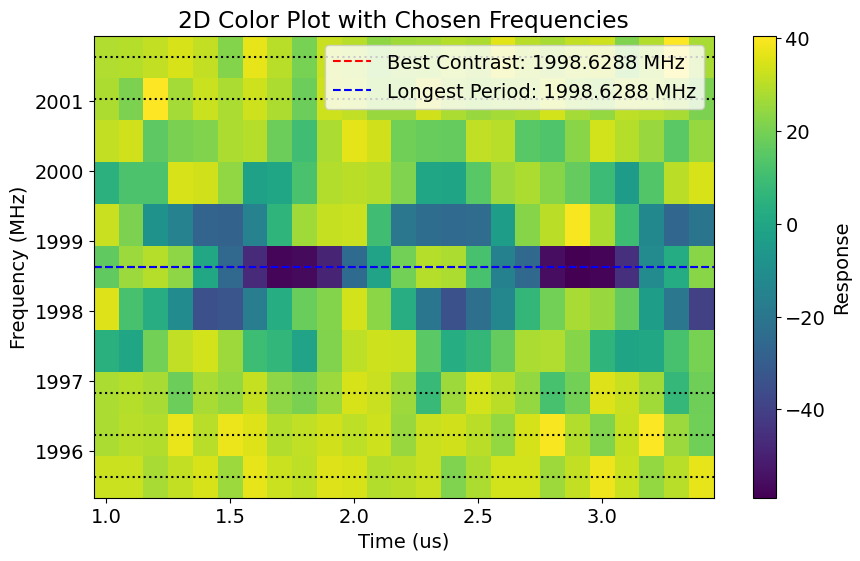

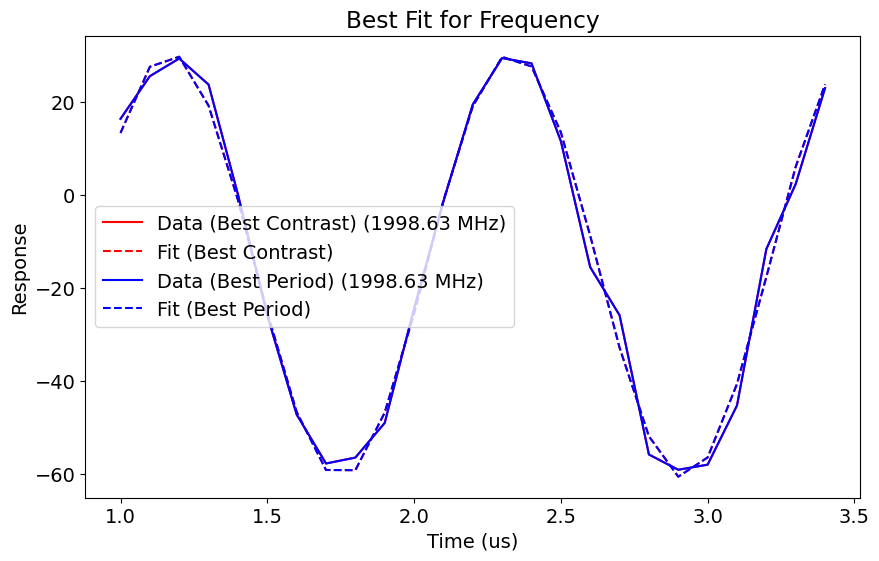

Saving D:\experiments\test_sweep_runner\data\00000_LengthRabiGeneralF0g1Experiment_sweep.h5
Complete. Saved to D:\experiments\test_sweep_runner\data\00000_LengthRabiGeneralF0g1Experiment_sweep.h5
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid


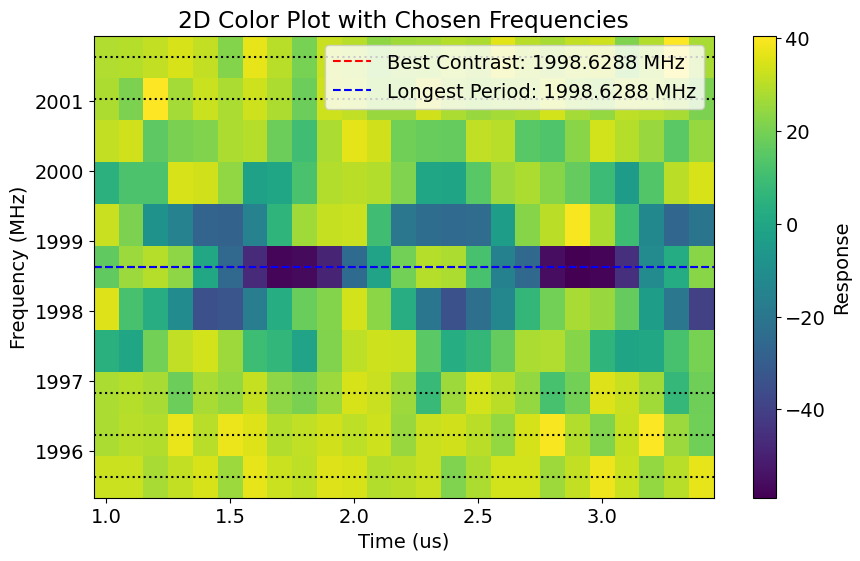

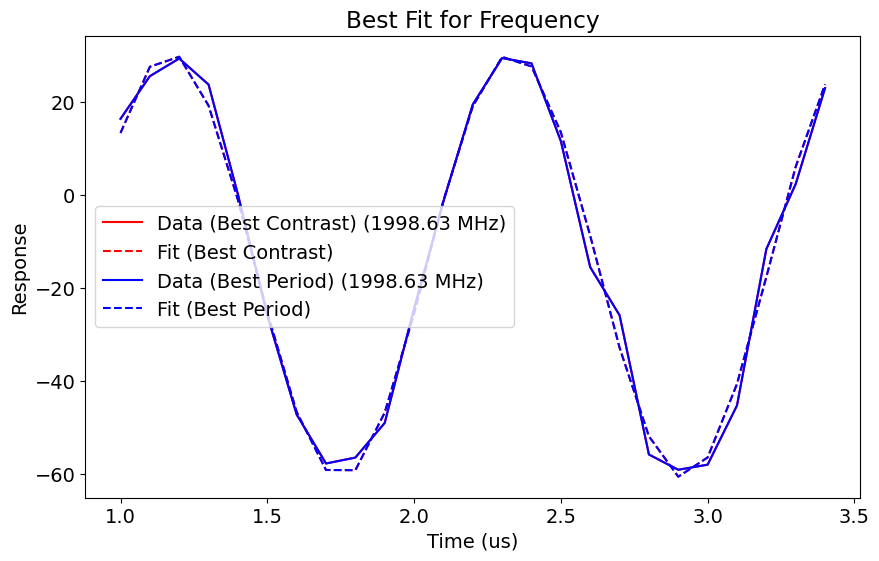

Best frequency found: 1998.6288 MHz
Creating or updating new csv at path: D:\python\multimode_expts\configs\man1_storage_swap_dataset_new.csv
Updated M1 frequency to 1998.6288 MHz
Sweep run example (uncomment with hardware)


In [7]:
# # Coarse sweep example
result = runner.run(
    sweep_start=station.ds_thisrun.get_freq('M1') - 3,
    sweep_stop=station.ds_thisrun.get_freq('M1') + 3,
    sweep_npts=11,
    gain=station.ds_thisrun.get_gain('M1'),
    start=1,  # time start in us
)

print("Sweep run example (uncomment with hardware)")

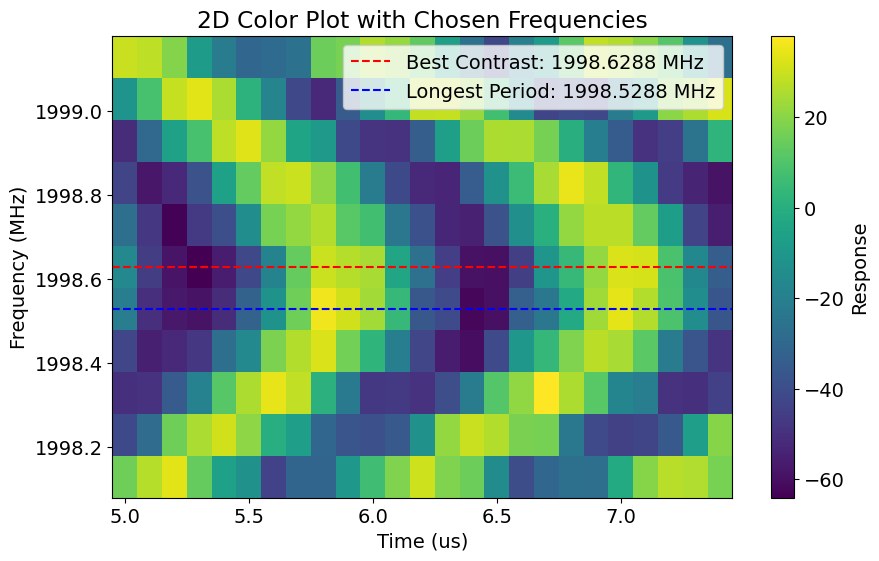

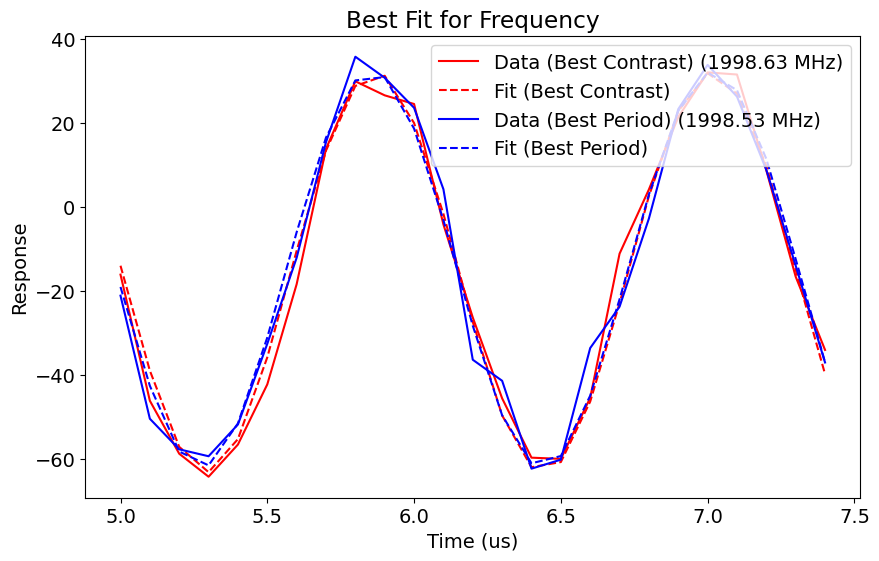

Saving D:\experiments\test_sweep_runner\data\00001_LengthRabiGeneralF0g1Experiment_sweep.h5
Complete. Saved to D:\experiments\test_sweep_runner\data\00001_LengthRabiGeneralF0g1Experiment_sweep.h5


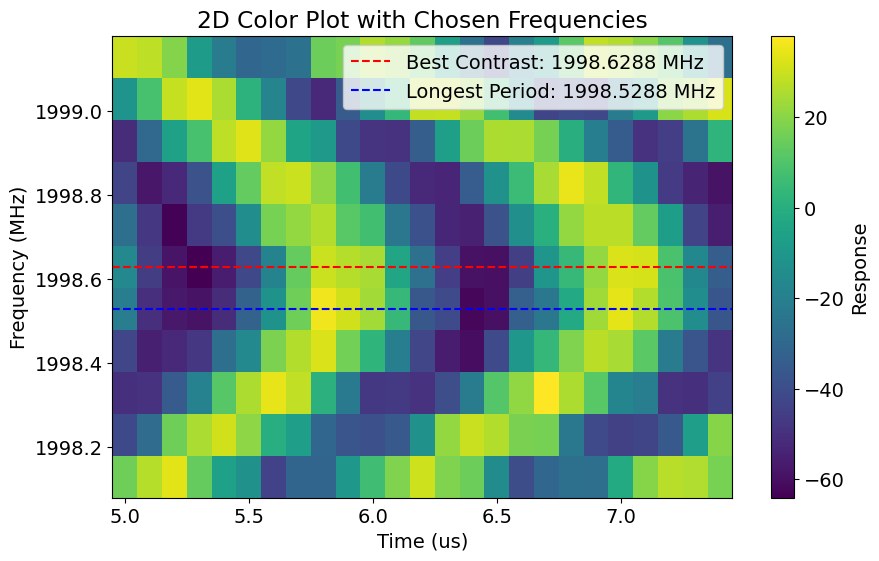

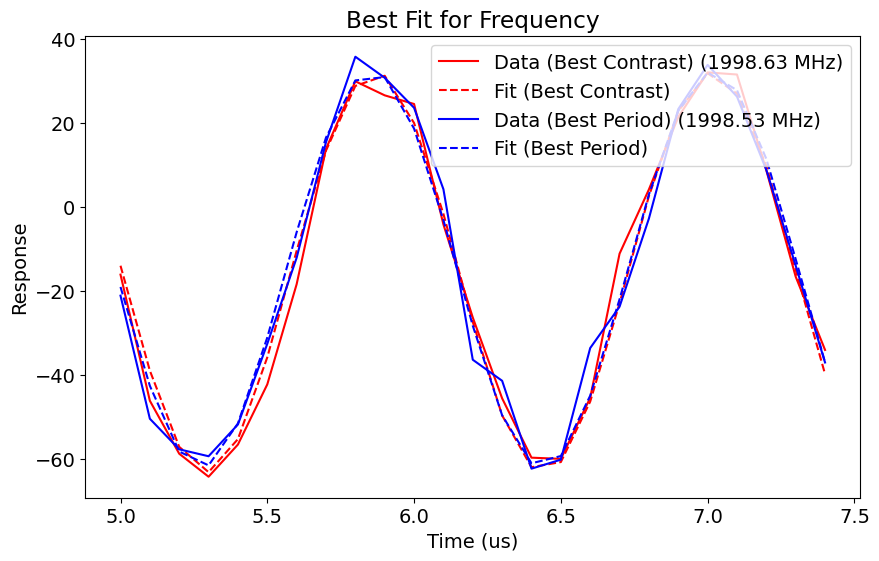

Best frequency found: 1998.6288 MHz
Creating or updating new csv at path: D:\python\multimode_expts\configs\man1_storage_swap_dataset_new.csv
Updated M1 frequency to 1998.6288 MHz
Fine sweep example (uncomment with hardware)


In [8]:
# Fine sweep example
result = runner.run(
    sweep_start=station.ds_thisrun.get_freq('M1') - 0.5,
    sweep_stop=station.ds_thisrun.get_freq('M1') + 0.5,
    sweep_npts=11,
    gain=station.ds_thisrun.get_gain('M1'),
    start=5,  # time start in us
)

print("Fine sweep example (uncomment with hardware)")

## Accessing Results

After the sweep completes, you can access:
```python
# The raw 2D data
result.data['freq_sweep']  # frequency values
result.data['xpts']        # time points (2D array)
result.data['avgi']        # I data (2D array: freq x time)

# The analysis results
result._chevron_analysis.results['best_frequency_contrast']
result._chevron_analysis.results['best_frequency_period']
```

In [ ]:
# # Example: accessing results
# print(f"Data shape: {result.data['avgi'].shape}")
# print(f"Best frequency: {result._chevron_analysis.results['best_frequency_contrast']:.4f} MHz")

print("Result access example (uncomment with hardware)")

## Running Mock Tests

To test without hardware, run the mock tests:

In [ ]:
# Run the mock tests
import subprocess
result = subprocess.run(
    ['python', 'test_sweep_runner.py'],
    capture_output=True,
    text=True,
    cwd='.'
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr)